In [1]:
import numpy as np
import pandas as pd 
from itertools import product
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
import lightgbm as lgb


pd.set_option('display.max_columns', 30)

# **Datasets research**

**Dataset items**

In [2]:
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [3]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [4]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [5]:
print('Unique values of product names: {}'.format(items.item_name.unique()))
print()
print('Number of unique values of products: {}'.format(items.item_name.nunique()))

Unique values of product names: ['! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D'
 '!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]'
 '***В ЛУЧАХ СЛАВЫ   (UNV)                    D' ...
 'Язык запросов 1С:Предприятия 8 (+CD). Хрусталева Е.Ю.'
 'Яйцо для Little Inu' 'Яйцо дракона (Игра престолов)']

Number of unique values of products: 22170


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


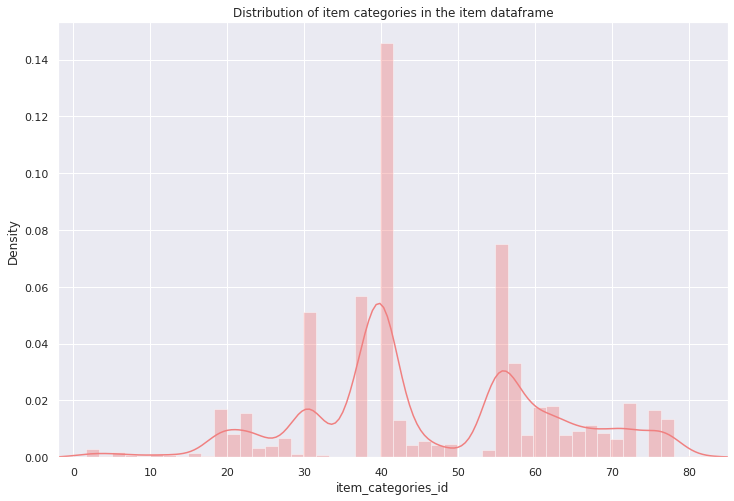

In [6]:
def simple_hist(data, x, bins, title, xlabel, xmin, xmax):
    plt.figure(figsize = (12, 8))
    sns.set()
    sns.distplot(data[x], color = 'lightcoral')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xlim(xmin, xmax)
    plt.show()

simple_hist(items, 'item_category_id', 10, 
            'Distribution of item categories in the item dataframe', 'item_categories_id', -2, 85)

**Dataset item_categories**

In [7]:
item_categories = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [9]:
item_categories.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [10]:
print('Unique values of product identifiers: {}'.format(item_categories.item_category_id.unique()))
print()
print('Number of unique values of product identifiers: {}'.format(item_categories.item_category_id.nunique()))

Unique values of product identifiers: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]

Number of unique values of product identifiers: 84


**Dataset shops**

In [11]:
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [13]:
shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


In [14]:
print('Unique meanings of store names: {}'.format(shops.shop_name.unique()))
print()
print('Number of unique store values: {}'.format(shops.shop_name.nunique()))

Unique meanings of store names: ['!Якутск Орджоникидзе, 56 фран' '!Якутск ТЦ "Центральный" фран'
 'Адыгея ТЦ "Мега"' 'Балашиха ТРК "Октябрь-Киномир"'
 'Волжский ТЦ "Волга Молл"' 'Вологда ТРЦ "Мармелад"'
 'Воронеж (Плехановская, 13)' 'Воронеж ТРЦ "Максимир"'
 'Воронеж ТРЦ Сити-Парк "Град"' 'Выездная Торговля'
 'Жуковский ул. Чкалова 39м?' 'Жуковский ул. Чкалова 39м²'
 'Интернет-магазин ЧС' 'Казань ТЦ "Бехетле"' 'Казань ТЦ "ПаркХаус" II'
 'Калуга ТРЦ "XXI век"' 'Коломна ТЦ "Рио"' 'Красноярск ТЦ "Взлетка Плаза"'
 'Красноярск ТЦ "Июнь"' 'Курск ТЦ "Пушкинский"' 'Москва "Распродажа"'
 'Москва МТРЦ "Афи Молл"' 'Москва Магазин С21'
 'Москва ТК "Буденовский" (пав.А2)' 'Москва ТК "Буденовский" (пав.К7)'
 'Москва ТРК "Атриум"' 'Москва ТЦ "Ареал" (Беляево)'
 'Москва ТЦ "МЕГА Белая Дача II"' 'Москва ТЦ "МЕГА Теплый Стан" II'
 'Москва ТЦ "Новый век" (Новокосино)' 'Москва ТЦ "Перловский"'
 'Москва ТЦ "Семеновский"' 'Москва ТЦ "Серебряный Дом"'
 'Мытищи ТРК "XL-3"' 'Н.Новгород ТРЦ "РИО"' 'Н.Новгород Т

**Dataset train**

In [15]:
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [17]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


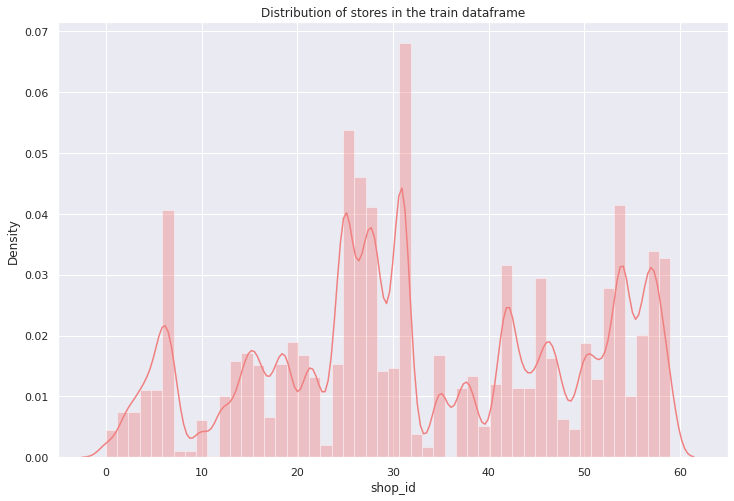

In [18]:
simple_hist(train, 'shop_id', 10, 
            'Distribution of stores in the train dataframe', 'shop_id', -5, 65)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


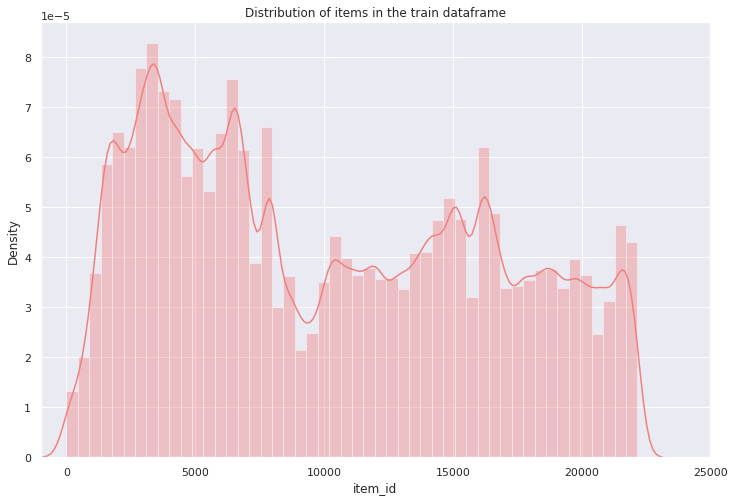

In [19]:
simple_hist(train, 'item_id', 30, 
            'Distribution of items in the train dataframe', 'item_id', -1000, 25000)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


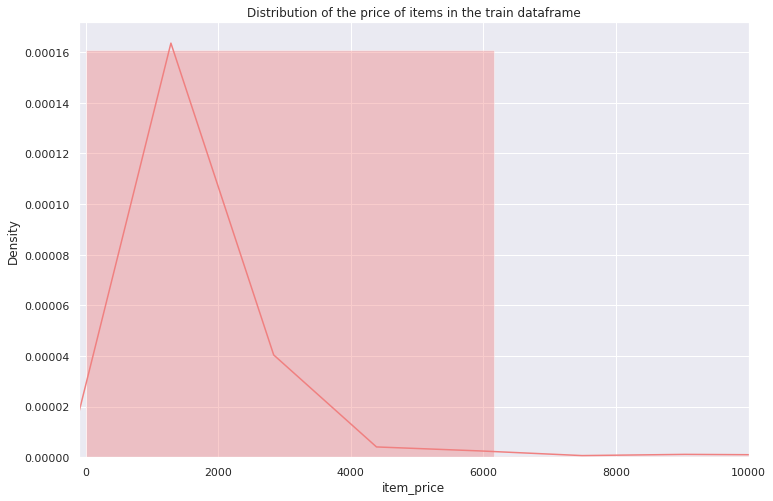

In [20]:
simple_hist(train, 'item_price', 1000, 
            'Distribution of the price of items in the train dataframe', 'item_price', -100, 10000)

Text(0, 0.5, 'item_price')

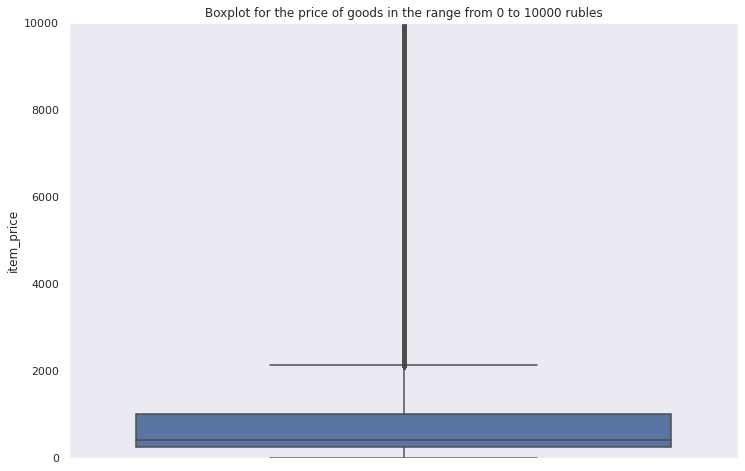

In [21]:
plt.figure(figsize = (12, 8))
sns.boxplot(y=train['item_price'])
plt.ylim(0, 10000)
plt.grid()
plt.title('Boxplot for the price of goods in the range from 0 to 10000 rubles')
plt.ylabel('item_price')

In [22]:
# the histogram is uninformative - it is better to look at the numbers
train.item_cnt_day.value_counts()

1.0      2629372
2.0       194201
3.0        47350
4.0        19685
5.0        10474
          ...   
412.0          1
164.0          1
624.0          1
539.0          1
161.0          1
Name: item_cnt_day, Length: 198, dtype: int64

**Dataset test**

In [23]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [25]:
test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


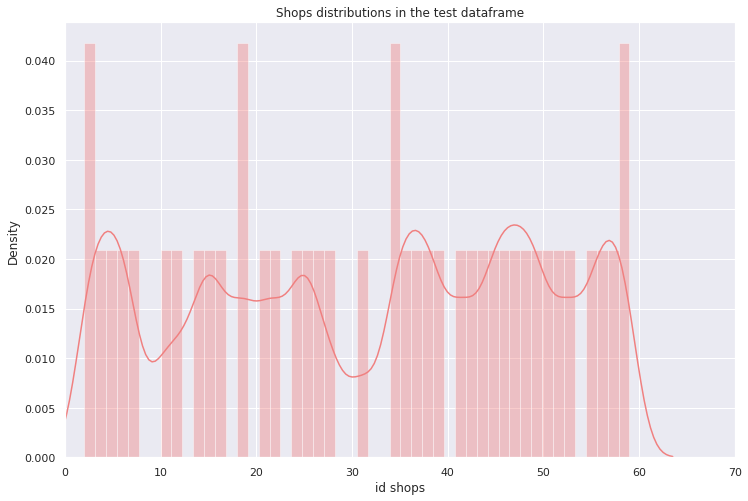

In [26]:
simple_hist(test, 'shop_id', 10, 
            'Shops distributions in the test dataframe', 'id shops', 0, 70)
# the distributions of the training and test datasets are different in this fic

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


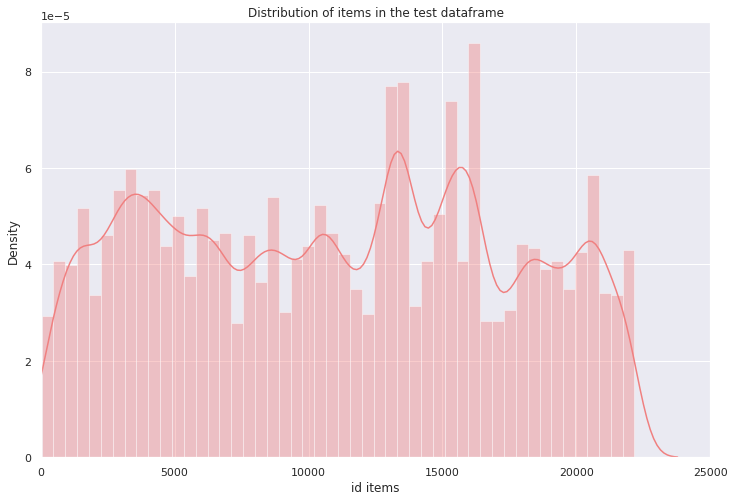

In [27]:
simple_hist(test, 'item_id', 30, 
            'Distribution of items in the test dataframe', 'id items', 0, 25000)
# the distributions of the training and test datasets are similar in this feature

**Dataset submission**

In [28]:
sample_submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')

In [29]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


**Data Leakage**

Around 42% of training shop_id ~ item_id pairs are present in test set, but I don't use it.

In [30]:
df_temp = pd.Series(list(train[['item_id', 'shop_id']].itertuples(index=False, name=None)))
test_iter_temp = pd.Series(list(test[['item_id', 'shop_id']].itertuples(index=False, name=None)))
print(str(round(df_temp.isin(test_iter_temp).sum()/len(df_temp),2)*100)+'%')

42.0%


In [31]:
#test_shop_ids = test['shop_id'].unique()
#test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
#train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
#train = train[train['item_id'].isin(test_item_ids)]

# **Prepare and feature engineering data**

In [32]:
# remove outliers
train = train[train.item_price < 100000]
train = train[train.item_cnt_day <= 900]

**Aggregate train data**

Since the test data is generated with combination of shops and items, we have to restructure train data to match the test data generation.

In [33]:
# aggregate
index_cols = ['shop_id', 'item_id', 'date_block_num']

# compute all shops/items combinations
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [34]:
# add sale for month
train_merge = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum'})
train_merge.columns = ['item_cnt_month']
train_merge.reset_index(inplace=True)

In [35]:
# merge grid and train
train_merge = pd.merge(grid, train_merge, on = index_cols, how='left').fillna(0)
train_merge['item_cnt_month'] = train_merge['item_cnt_month'].clip(0, 40)

**Merge train and item datasets**

In [36]:
items_prepare = pd.merge(items, item_categories, on='item_category_id')
train_merge = pd.merge(train_merge, items_prepare, on = ['item_id'], how = 'left')

**Prepare test**

In [37]:
# prepare to concat with train
test_temp = test.copy()
test_temp['date_block_num'] = 34
test_temp.drop('ID', axis=1, inplace=True)

In [38]:
# merge with items and item_category
test_temp = test_temp.merge(items, how='left', on='item_id')
test_temp = test_temp.merge(item_categories, how='left', on='item_category_id')
test_temp.drop('item_name', axis=1, inplace=True)

In [39]:
# concat test and train dataframes
train_merge = pd.concat([train_merge, test_temp], axis=0, ignore_index=True, keys=index_cols)
train_merge.fillna(0, inplace=True)

**Prepare items features**

Categorization of products.

In [40]:
map_dict = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }
# extract common categories
train_merge['item_category'] = train_merge['item_category_name'].apply(lambda x: x.split('-')[0])
train_merge['item_category'] = train_merge['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)
# encoding common categories
train_merge['item_category_common'] = LabelEncoder().fit_transform(train_merge['item_category'])

**Prepare shops features**

Extract and encode the names of cities. Add new features - coordinates of cities and parts of the country.

In [41]:
# extract and encode cities
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
# add coordinates of cities
coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])

shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]

In [42]:
train_merge = pd.merge(train_merge, shops, on = ['shop_id'], how='left')

In [43]:
train_merge.drop(['item_name', 'item_category_name', 'item_category'], axis=1, inplace=True)

In [44]:
train_merge.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_category_common,city_code,city_coord_1,city_coord_2,country_part
0,59,22154,0,1.0,37,11,30,57.62987,39.87368,2
1,59,2552,0,0.0,58,13,30,57.62987,39.87368,2
2,59,2554,0,0.0,58,13,30,57.62987,39.87368,2
3,59,2555,0,0.0,56,13,30,57.62987,39.87368,2
4,59,2564,0,0.0,59,13,30,57.62987,39.87368,2


**Generate lag feature and mean encoding**

In [45]:
# define lag_feature
def lag_feature(data, lags, column):
    temp = data[['date_block_num', 'shop_id', 'item_id', column]]
    for lag in lags:
        shifted = temp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', column + '_lag_' + str(lag)]
        shifted['date_block_num'] += lag
        data = pd.merge(data, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        data[column+'_lag_'+str(lag)] = data[column+'_lag_'+str(lag)].astype('float16')
    return data

In [46]:
# add sales lags for last 3 months
train_merge = lag_feature(train_merge, [1, 2, 3], 'item_cnt_month')

In [47]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   shop_id               int64  
 1   item_id               int64  
 2   date_block_num        int64  
 3   item_cnt_month        float64
 4   item_category_id      int64  
 5   item_category_common  int64  
 6   city_code             int64  
 7   city_coord_1          float64
 8   city_coord_2          float64
 9   country_part          int64  
 10  item_cnt_month_lag_1  float16
 11  item_cnt_month_lag_2  float16
 12  item_cnt_month_lag_3  float16
dtypes: float16(3), float64(3), int64(7)
memory usage: 997.6 MB


In [48]:
# value reduction
def value_reduction(data):
    for column in data.columns:
        if data[column].dtype == 'float64':
            data[column] = data[column].astype(np.float32)
        if (data[column].dtype == 'int64' or data[column].dtype == 'int32') and (data[column].max() < 32767 and data[column].min() > -32768) and data[column].isnull().sum()==0:
            data[column] = data[column].astype(np.int16)
    return data

train_merge = value_reduction(train_merge)

In [49]:
# add mean encoding for items for last 3 month
item_id_target_mean = train_merge.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
train_merge = pd.merge(train_merge, item_id_target_mean, on=['date_block_num','item_id'], how='left')

train_merge['item_target_enc'] = (train_merge['item_target_enc']
                                .fillna(0)
                                .astype(np.float16))

train_merge = lag_feature(train_merge, [1, 2, 3], 'item_target_enc')
train_merge.drop(['item_target_enc'], axis=1, inplace=True)

In [50]:
# add target encoding for item/city for last 3 months
item_id_target_mean = train_merge.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
train_merge = pd.merge(train_merge, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

train_merge['item_loc_target_enc'] = (train_merge['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

train_merge = lag_feature(train_merge, [1, 2, 3], 'item_loc_target_enc')
train_merge.drop(['item_loc_target_enc'], axis=1, inplace=True)

In [51]:
# add target encoding for item/shop for last 3 months 
item_id_target_mean = train_merge.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_shop_target_enc"}, errors="raise")

train_merge = pd.merge(train_merge, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

train_merge['item_shop_target_enc'] = (train_merge['item_shop_target_enc']
                                .fillna(0)
                                .astype(np.float16))

train_merge = lag_feature(train_merge, [1, 2, 3], 'item_shop_target_enc')
train_merge.drop(['item_shop_target_enc'], axis=1, inplace=True)

In [52]:
# interaction features
first_item_block = train_merge.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

first_shop_item_buy_block = train_merge[train_merge['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

In [53]:
# merge train and new features
train_merge = pd.merge(train_merge, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
train_merge = pd.merge(train_merge, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

In [54]:
# fillna and change type
train_merge['first_date_block_num'].fillna(100, inplace=True)
train_merge['shop_item_sold_before'] = (train_merge['first_date_block_num'] < train_merge['date_block_num']).astype('int8')
train_merge.drop(['first_date_block_num'], axis=1, inplace=True)

train_merge['item_first_interaction'].fillna(0, inplace=True)
train_merge['shop_item_sold_before'].fillna(0, inplace=True)
 
train_merge['item_first_interaction'] = train_merge['item_first_interaction'].astype('int8')  
train_merge['shop_item_sold_before'] = train_merge['shop_item_sold_before'].astype('int8') 

In [55]:
# add avg category for new features
item_id_target_mean = train_merge[train_merge['item_first_interaction'] == 1].groupby(['date_block_num','item_category_id'])['item_cnt_month'].mean().reset_index().rename(columns={'item_cnt_month': 'new_item_cat_avg'}, errors='raise')

train_merge = pd.merge(train_merge, item_id_target_mean, on=['date_block_num','item_category_id'], how='left')

train_merge['new_item_cat_avg'] = (train_merge['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

train_merge = lag_feature(train_merge, [1, 2, 3], 'new_item_cat_avg')
train_merge.drop(['new_item_cat_avg'], axis=1, inplace=True)

In [56]:
train_merge.isna().sum()

shop_id                             0
item_id                             0
date_block_num                      0
item_cnt_month                      0
item_category_id                    0
item_category_common                0
city_code                           0
city_coord_1                        0
city_coord_2                        0
country_part                        0
item_cnt_month_lag_1          2522543
item_cnt_month_lag_2          3174870
item_cnt_month_lag_3          3783240
item_target_enc_lag_1         2522543
item_target_enc_lag_2         3174870
item_target_enc_lag_3         3783240
item_loc_target_enc_lag_1     2522543
item_loc_target_enc_lag_2     3174870
item_loc_target_enc_lag_3     3783240
item_shop_target_enc_lag_1    2522543
item_shop_target_enc_lag_2    3174870
item_shop_target_enc_lag_3    3783240
item_first_interaction              0
shop_item_sold_before               0
new_item_cat_avg_lag_1        2522543
new_item_cat_avg_lag_2        3174870
new_item_cat

In [57]:
# fill Nan values to 0
train_merge.fillna(0, inplace=True)
# take data only after 3 since the most lag month interval is 3
train_merge = train_merge[train_merge['date_block_num'] > 2]

In [58]:
# save finished dataset to pickle
train_merge.to_pickle('train_merge.pkl')

In [59]:
# split dataset 
X_train = train_merge[train_merge.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = train_merge[train_merge.date_block_num < 33]['item_cnt_month']
X_valid = train_merge[train_merge.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = train_merge[train_merge.date_block_num == 33]['item_cnt_month']
X_test = train_merge[train_merge.date_block_num == 34].drop(['item_cnt_month'], axis=1)
print('Shape X_train: {}'.format(X_train.shape))
print()
print('Shape y_train: {}'.format(y_train.shape))
print()
print('Shape X_valid: {}'.format(X_valid.shape))
print()
print('Shape y_valid: {}'.format(y_valid.shape))
print()
print('Shape X_test: {}'.format(X_test.shape))

Shape X_train: (9552837, 26)

Shape y_train: (9552837,)

Shape X_valid: (238172, 26)

Shape y_valid: (238172,)

Shape X_test: (214200, 26)


# **Fit models**

**Catboost**

In [60]:
cat_features = ['country_part', 
                'item_category_common',
                'item_category_id', 
                'city_code']

catboost = CatBoostRegressor(random_state=1, 
                             iterations=2000, verbose=200, depth = 4, 
                             learning_rate=0.01, l2_leaf_reg=7,
                             max_leaves = 2047, min_data_in_leaf = 1,
                             subsample = 0.7,
                             loss_function='RMSE', eval_metric='RMSE',
                             task_type='GPU',early_stopping_rounds=30,
                             grow_policy='Lossguide', bootstrap_type='Poisson',
                            cat_features=cat_features)

In [61]:
catboost.fit(X_train, y_train)

0:	learn: 1.4678309	total: 68ms	remaining: 2m 15s
200:	learn: 1.1389988	total: 9.45s	remaining: 1m 24s
400:	learn: 1.1088690	total: 19s	remaining: 1m 15s
600:	learn: 1.0987080	total: 28.6s	remaining: 1m 6s
800:	learn: 1.0905264	total: 39s	remaining: 58.4s
1000:	learn: 1.0843354	total: 48.5s	remaining: 48.4s
1200:	learn: 1.0795526	total: 57.9s	remaining: 38.5s
1400:	learn: 1.0755754	total: 1m 7s	remaining: 28.7s
1600:	learn: 1.0719159	total: 1m 16s	remaining: 19.1s
1800:	learn: 1.0690616	total: 1m 25s	remaining: 9.48s
1999:	learn: 1.0664707	total: 1m 35s	remaining: 0us


In [62]:
# save catboost model
pickle.dump(catboost, open('catboost.sav', 'wb'))

In [63]:
predict_cb_train = catboost.predict(X_train)
predict_cb_valid = catboost.predict(X_valid)
predict_cb_test = catboost.predict(X_test)
print('Train rmse for Catboost:', np.sqrt(mean_squared_error(y_train, predict_cb_train)))
print('Validation rmse for Catboost:', np.sqrt(mean_squared_error(y_valid, predict_cb_valid)))

Train rmse for Catboost: 1.066154356973836
Validation rmse for Catboost: 1.1238282093641259


**LinearRegression**

In [64]:
lr_features = ['item_target_enc_lag_1', 'item_target_enc_lag_2',
              'item_loc_target_enc_lag_1', 'item_loc_target_enc_lag_2', 'item_loc_target_enc_lag_3', 
               'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']
lr_train = X_train[lr_features]
lr_val = X_valid[lr_features]
lr_test = X_test[lr_features]


lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_valid = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

lr_level1 = LinearRegression()
lr_level1.fit(lr_train, y_train)

LinearRegression()

In [65]:
# save linear regression model
pickle.dump(lr_level1, open('lr_level1.sav', 'wb'))

In [66]:
predict_lr_train = lr_level1.predict(lr_train)
predict_lr_valid = lr_level1.predict(lr_valid)
predict_lr_test = lr_level1.predict(lr_test)
print('Train rmse for LinearRegression:', np.sqrt(mean_squared_error(y_train, predict_lr_train)))
print('Validation rmse for LinearRegression:', np.sqrt(mean_squared_error(y_valid, predict_lr_valid)))

Train rmse for LinearRegression: 1.1768253
Validation rmse for LinearRegression: 1.197905


**LightGBM**

In [67]:
# define build model function
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), verbose_eval=50,
                     categorical_feature=cat_features)
    return model

# define parameters
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction': 0.7,
    'learning_rate': 0.01,
    'num_rounds': 2000,
    'early_stopping_rounds': 30,
    'seed': 1
}
# fit model
lgb_model = build_lgb_model(params, X_train, X_valid, y_train, y_valid, cat_features)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'country_part', 'item_category_common', 'item_category_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.200837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 9552837, number of used features: 26


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.306574
Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 1.20543	valid_1's rmse: 1.21775
[100]	training's rmse: 1.06151	valid_1's rmse: 1.15071
[150]	training's rmse: 0.983443	valid_1's rmse: 1.13379
Early stopping, best iteration is:
[151]	training's rmse: 0.982032	valid_1's rmse: 1.13373


In [68]:
# save lightgbm model
pickle.dump(lgb_model, open('lgb_1.sav', 'wb'))

In [69]:
predict_lgb_train = lgb_model.predict(X_train)
predict_lgb_valid = lgb_model.predict(X_valid)
predict_lgb_test = lgb_model.predict(X_test)
print('Train rmse for LightGBM:', np.sqrt(mean_squared_error(y_train, predict_lgb_train)))
print('Validation rmse for LightGBM:', np.sqrt(mean_squared_error(y_valid, predict_lgb_valid)))

Train rmse for LightGBM: 0.9820316648492755
Validation rmse for LightGBM: 1.1337275307720496


**RandomForest**

In [70]:
rf = RandomForestRegressor(random_state = 1, max_depth=10, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=11, n_estimators=75)

In [71]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=11, n_estimators=75, random_state=1)

In [72]:
pickle.dump(rf, open('rf.sav', 'wb'))

In [73]:
predict_rf_train = rf.predict(X_train)
predict_rf_valid = rf.predict(X_valid)
predict_rf_test = rf.predict(X_test)
print('Train rmse for RandomForest:', np.sqrt(mean_squared_error(y_train, predict_rf_train)))
print('Validation rmse for RandomForest:', np.sqrt(mean_squared_error(y_valid, predict_rf_valid)))

Train rmse for RandomForest: 1.0858039000940345
Validation rmse for RandomForest: 1.1336352673662384


**Ensemble model**

Ensemble architecture:
1st level:
* Catboost
* XGBM
* Random forest
* Linear Regression

2nd level:
* Linear Regression

In [74]:
# dataset that will be the train set of the ensemble model
first_level = pd.DataFrame(predict_cb_valid, columns=['catboost'])
first_level['lightgbm'] = predict_lgb_valid
first_level['random_forest'] = predict_rf_valid
first_level['linear_regression'] = predict_lr_valid
first_level['label'] = y_valid.values
first_level.head(5)

,catboost,lightgbm,random_forest,linear_regression,label
0,0.008289,0.100555,0.056775,0.085277,1.0
1,1.000518,0.701159,0.982985,0.902108,1.0
2,0.568380,0.436898,0.572419,0.768765,2.0
3,0.125713,0.180264,0.154142,0.112127,1.0
4,0.428278,0.585017,0.545204,0.173981,1.0


In [75]:
# dataset that will be the test set of the ensemble model
first_level_test = pd.DataFrame(predict_cb_test, columns=['catboost'])
first_level_test['lightgbm'] = predict_lgb_test
first_level_test['random_forest'] = predict_rf_test
first_level_test['linear_regression'] = predict_lr_test
first_level_test.head()

,catboost,lightgbm,random_forest,linear_regression
0,0.392435,0.497160,0.506160,0.410781
1,0.318272,0.290975,0.228292,0.085470
2,0.864805,0.820538,1.058583,0.973902
3,0.310515,0.396488,0.388645,0.211888
4,4.584531,1.640624,1.908433,0.085470


In [76]:
meta_model = LinearRegression(n_jobs=-1)

In [77]:
X_first_level = first_level.drop('label', axis=1)
y_first_level = first_level['label']

In [78]:
# trained on validation set using the 1st level models predictions as features
meta_model.fit(X_first_level, y_first_level)

LinearRegression(n_jobs=-1)

In [79]:
# make predictions on test set using the 1st level models predictions as feature
ensemble_pred_test = meta_model.predict(first_level_test).clip(0, 20)

In [80]:
# save ensemble model
pickle.dump(meta_model, open('meta_model.sav', 'wb'))

**Predict and submit task**

In [81]:
lgb_submission = pd.DataFrame({
    'ID': test.index, 
    'item_cnt_month': lgb_model.predict(X_test).clip(0, 20)
})
lgb_submission.to_csv('lgb_submission.csv', index=False)
print(lgb_submission)

ensemble_submission = pd.DataFrame({
    'ID': test.index, 
    'item_cnt_month': ensemble_pred_test
})
ensemble_submission.to_csv('ensemble_submission.csv', index=False)
print(ensemble_submission)

            ID  item_cnt_month
0            0        0.497160
1            1        0.290975
2            2        0.820538
3            3        0.396488
4            4        1.640624
...        ...             ...
214195  214195        0.169234
214196  214196        0.099426
214197  214197        0.108887
214198  214198        0.091597
214199  214199        0.108881

[214200 rows x 2 columns]
            ID  item_cnt_month
0            0        0.466711
1            1        0.301054
2            2        0.903041
3            3        0.379483
4            4        3.149060
...        ...             ...
214195  214195        0.110581
214196  214196        0.036771
214197  214197        0.055804
214198  214198        0.040422
214199  214199        0.057712

[214200 rows x 2 columns]


**Total score**
* LightGBM model (public score) - 0.8981
* LightGBM model (private score) - 0.9120
* Ensemble model (public score) - 0.9050
* Ensemble model (private score) - 0.9070